In [1]:
# !pip install odfpy
# !pip install seaborn
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import yaml
from yaml import Loader
import numpy as np
import analyze_cells_energy as ace
import utils
from scipy.stats import ttest_ind, mannwhitneyu

In [2]:
root_directory = '/home/stella/Documents/Torino/projects/'
experiment = 'SexualImprinting'
experimental_group = 'SWISS_WF_1_24_2023'
data_directory = root_directory + experiment + '/' \
                + experimental_group + '/'
subjects = [name for name in os.listdir(data_directory) \
                if os.path.isdir(os.path.join(data_directory, name))]

In [3]:
subjects.remove('SW4Unfam')

In [4]:
# load query file where we added volumes for each area
volumes = pd.read_csv("query_volumes_reordered.csv")
volumes = ace.clean_volumes_database(volumes)

In [5]:
def load_subject(subject):
    df_mouse = pd.read_csv(data_directory + subject + '/cells300.csv')
    df_mouse = ace.reformat_df_mouse(df=df_mouse)
    return df_mouse

# Analysis on SWISS WF 1 24 2023

In [8]:
# NB: Run only if file does not exist or needs to be regenerated
dict_results_across_mice = {subject: ace.calculate_cells_energy_per_level(df_mouse=load_subject(subject), 
                                                                          vol=volumes, 
                                                                          level=8) for subject in subjects}
np.save('dict_results_across_mice_SW_WF_1_24_2023-300.npy', dict_results_across_mice)

/home/stella/anaconda2/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3418: DtypeWarning: Columns (12) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [9]:
dict_results_across_mice = np.load('dict_results_across_mice_SW_WF_1_24_2023-300.npy', allow_pickle=True).item()

# List areas with null cell count

In [15]:
db_null_count = {subject: dict_results_across_mice[subject][
    dict_results_across_mice[subject].n_cells == 0] for subject in subjects}

# List areas with no volume

In [16]:
db_null_volume = {subject: dict_results_across_mice[subject][
    dict_results_across_mice[subject]['energy'].isnull()] for subject in subjects}

# Divide mice into experimental groups: FAM/UNFAM/CONTROL

In [17]:
experimental_groups = utils.divide_in_exp_groups(list_subjects=subjects)
experimental_groups

{'Control': ['SW12Control',
  'SW16Control',
  'SW23Control',
  'SW21Control',
  'SW8Control',
  'SW1Control'],
 'Unfam': ['SW14Unfam', 'SW17Unfam', 'SW7Unfam', 'SW3Unfam'],
 'Fam': ['SW15Fam', 'SW2Fam', 'SW11Fam', 'SW22Fam', 'SW6Fam', 'SW19Fam']}

# Calculate cell count across experimental groups

In [18]:
df_control_cell_count, df_fam_cell_count, df_unfam_cell_count = \
ace.calculate_value_across_groups(experimental_groups=experimental_groups, 
                              dict_results_across_mice=dict_results_across_mice, 
                              value='n_cells')

## Calculate t-tests across groups per area

In [19]:
df_ttest_ncells = ace.test_across_groups(df_control=df_control_cell_count, 
                               df_fam=df_fam_cell_count, 
                               df_unfam=df_unfam_cell_count)
df_ttest_ncells

,area,pval_Control_vs_Fam,pval_Control_vs_Unfam,pval_Fam_vs_Unfam
0,Frontal pole cerebral cortex,0.126122,0.253682,0.757139
1,Primary motor area,0.489858,0.219965,0.562314
2,Secondary motor area,0.51038,0.205344,0.513777
3,Primary somatosensory area,0.468833,0.290782,0.706597
4,Supplemental somatosensory area,0.602202,0.259053,0.518431
...,...,...,...,...
293,Flocculus,0.0330126,0.759824,0.153258
294,Fastigial nucleus,0.495705,0.768814,0.432195
295,Interposed nucleus,0.0980615,0.494417,0.295607
296,Dentate nucleus,0.235501,0.511203,0.623733


In [20]:
# remove rows corresponding to area that have zero cell count across all experimental groups
df_ttest_not_null_ncells = df_ttest_ncells.dropna(axis=0,
                                   how='all',
                                   subset=['pval_Control_vs_Fam',
                                          'pval_Control_vs_Unfam',
                                          'pval_Fam_vs_Unfam'])

In [21]:
# sort dataframe pvalues of control vs fam and pick the first 20
df_ttest_not_null_ncells.sort_values(by='pval_Control_vs_Fam')[['area', 'pval_Control_vs_Fam']][0:20].set_index('area')

,pval_Control_vs_Fam
area,
Preparasubthalamic nucleus,0.00334878
Dorsal premammillary nucleus,0.00448849
Reticular nucleus of the thalamus,0.011837
Edinger-Westphal nucleus,0.0123471
Lateral dorsal nucleus of thalamus,0.022999
Declive (VI),0.0240521
Flocculus,0.0330126
Globus pallidus internal segment,0.0333427
Posterior complex of the thalamus,0.03854


In [22]:
# sort dataframe pvalues of control vs unfam and pick the first 20
df_ttest_not_null_ncells.sort_values(by='pval_Control_vs_Unfam')[['area', 'pval_Control_vs_Unfam']][0:20].set_index('area')

,pval_Control_vs_Unfam
area,
Edinger-Westphal nucleus,0.0187272
Posterior hypothalamic nucleus,0.0193972
Dorsomedial nucleus of the hypothalamus,0.0263947
Supramammillary nucleus,0.0310263
Medial mammillary nucleus,0.0377341
Parataenial nucleus,0.0435485
Medial preoptic nucleus,0.0516842
Subparaventricular zone,0.0544623
Subfornical organ,0.0623669


In [23]:
# sort dataframe pvalues of fam vs unfam and pick the first 20
df_ttest_not_null_ncells.sort_values(by='pval_Fam_vs_Unfam')[['area', 'pval_Fam_vs_Unfam']][0:20].set_index('area')

,pval_Fam_vs_Unfam
area,
Anterodorsal nucleus,0.00796236
Anteroventral nucleus of thalamus,0.0347854
Subparaventricular zone,0.052117
Dorsal part of the lateral geniculate complex,0.0584358
Central lateral nucleus of the thalamus,0.0599537
Medial geniculate complex,0.0608466
Preparasubthalamic nucleus,0.0697081
Medial preoptic nucleus,0.0706523
Mediodorsal nucleus of thalamus,0.0734504


## Mann Whitney Test for comparison across groups

In [24]:
df_mannwhitneyu_ncells = ace.test_across_groups(df_control=df_control_cell_count, 
                               df_fam=df_fam_cell_count, 
                               df_unfam=df_unfam_cell_count,
                                           test='mannwhitneyu')
df_mannwhitneyu_ncells

,area,pval_Control_vs_Fam,pval_Control_vs_Unfam,pval_Fam_vs_Unfam
0,Frontal pole cerebral cortex,0.114883,0.295889,0.297016
1,Primary motor area,0.287587,0.227773,0.227773
2,Secondary motor area,0.405091,0.227773,0.227773
3,Primary somatosensory area,0.235585,0.227773,0.227773
4,Supplemental somatosensory area,0.468093,0.168678,0.334435
...,...,...,...,...
293,Flocculus,0.0123609,0.457553,0.227773
294,Fastigial nucleus,0.235585,0.415332,0.227773
295,Interposed nucleus,0.0463479,0.260583,0.120477
296,Dentate nucleus,0.114883,0.227773,0.373818


In [25]:
# remove rows corresponding to area that have zero cell count across all experimental groups
df_mannwhitneyu_not_null_ncells = df_mannwhitneyu_ncells.dropna(axis=0,
                                   how='all',
                                   subset=['pval_Control_vs_Fam',
                                          'pval_Control_vs_Unfam',
                                          'pval_Fam_vs_Unfam'])

In [26]:
# sort dataframe pvalues of control vs fam and pick the first 20
df_mannwhitneyu_not_null_ncells.sort_values(by='pval_Control_vs_Fam')[['area', 'pval_Control_vs_Fam']][0:20].set_index('area')

,pval_Control_vs_Fam
area,
Preparasubthalamic nucleus,0.00213336
Dorsal premammillary nucleus,0.00362981
Zona incerta,0.00411951
Edinger-Westphal nucleus,0.00481086
Posterior limiting nucleus of the thalamus,0.0050034
Lateral dorsal nucleus of thalamus,0.00653261
Flocculus,0.0123609
Parastrial nucleus,0.0134428
Subthalamic nucleus,0.01474


In [27]:
# sort dataframe pvalues of control vs unfam and pick the first 20
df_mannwhitneyu_not_null_ncells.sort_values(by='pval_Control_vs_Unfam')[['area', 'pval_Control_vs_Unfam']][0:20].set_index('area')

,pval_Control_vs_Unfam
area,
Parataenial nucleus,0.0108685
Edinger-Westphal nucleus,0.0128854
Parastrial nucleus,0.0128854
Medial preoptic area,0.0214128
Dorsal motor nucleus of the vagus nerve,0.0266089
Dorsal nucleus raphe,0.0328618
Dorsomedial nucleus of the hypothalamus,0.0349772
Posterior hypothalamic nucleus,0.0349772
Arcuate hypothalamic nucleus,0.0430776


In [28]:
# sort dataframe pvalues of control vs fam and pick the first 20
df_mannwhitneyu_not_null_ncells.sort_values(by='pval_Fam_vs_Unfam')[['area', 'pval_Fam_vs_Unfam']][0:20].set_index('area')

,pval_Fam_vs_Unfam
area,
Anterodorsal nucleus,0.00710702
Subparaventricular zone,0.0201621
Anteroventral nucleus of thalamus,0.0214128
Mediodorsal nucleus of thalamus,0.0214128
Preparasubthalamic nucleus,0.0352713
Posterior limiting nucleus of the thalamus,0.0411504
Rhomboid nucleus,0.0421141
Central lateral nucleus of the thalamus,0.0435592
Inferior salivatory nucleus,0.0438344


## Calculate cross corr across groups per area on cell count

In [29]:
corr_matrix_control_ncells = ace.cross_corr(df_control_cell_count)
corr_matrix_fam_ncells = ace.cross_corr(df_fam_cell_count)
corr_matrix_unfam_ncells = ace.cross_corr(df_unfam_cell_count)

## Plot cross corr matrix across groups per area on cell count

Text(0.5, 1.0, 'CONTROL')

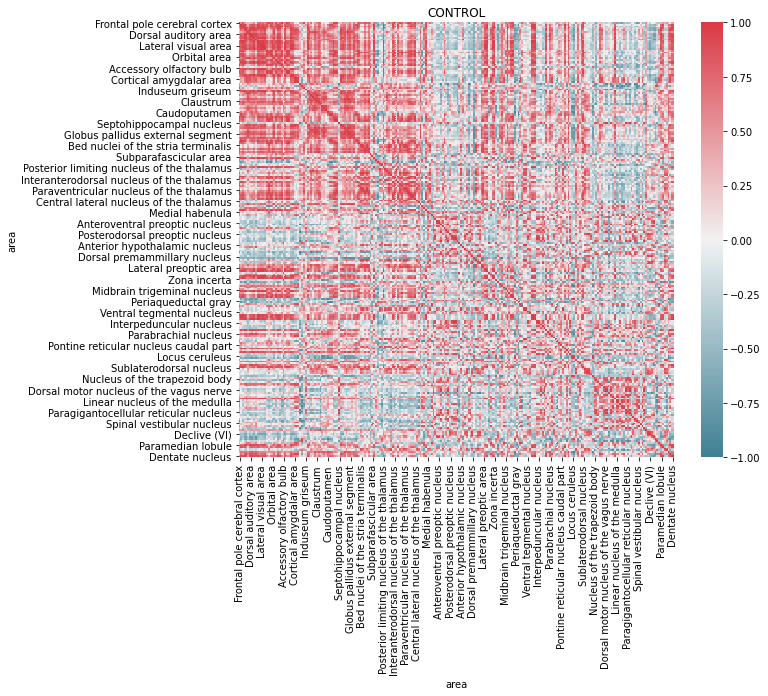

In [30]:
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr_matrix_control_ncells,
    cmap=sns.diverging_palette(220, 10, as_cmap=True),
    vmin=-1.0, vmax=1.0,
    square=True, ax=ax)
ax.set_title('CONTROL')

Text(0.5, 1.0, 'FAM')

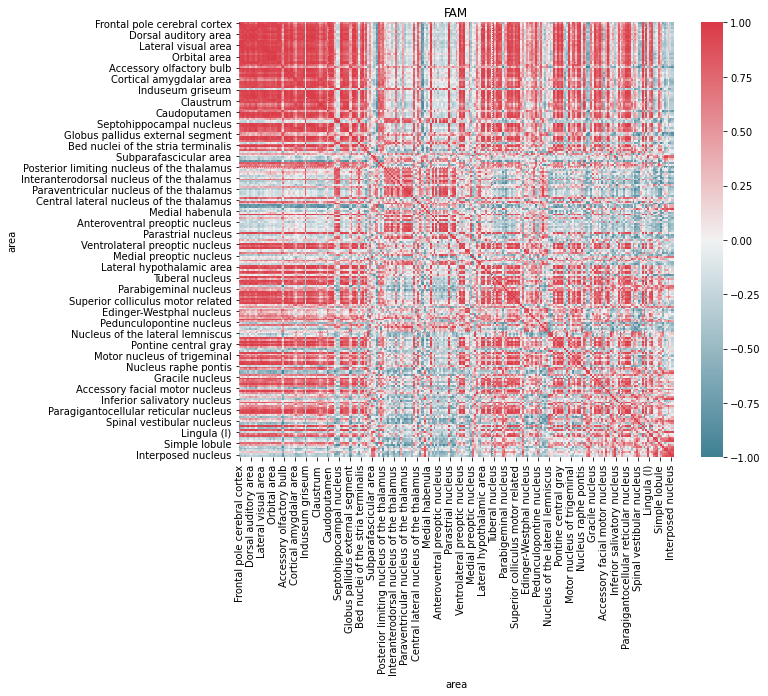

In [31]:
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr_matrix_fam_ncells,
    cmap=sns.diverging_palette(220, 10, as_cmap=True),
    vmin=-1.0, vmax=1.0,
    square=True, ax=ax)
ax.set_title('FAM')

Text(0.5, 1.0, 'UNFAM')

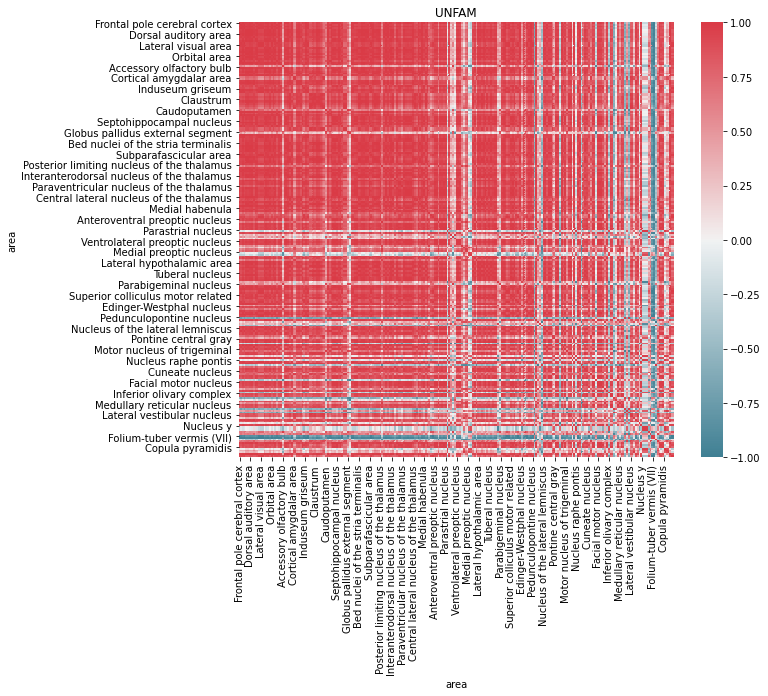

In [32]:
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr_matrix_unfam_ncells,
    cmap=sns.diverging_palette(220, 10, as_cmap=True),
    vmin=-1.0, vmax=1.0,
    square=True, ax=ax)
ax.set_title('UNFAM')

# Calculate energy across experimental groups

In [33]:
df_control_energy, df_fam_energy, df_unfam_energy = \
ace.calculate_value_across_groups(experimental_groups, dict_results_across_mice, value='energy')

## T-test on energy across groups

In [34]:
df_ttest_energy = ace.test_across_groups(df_control=df_control_energy,
                                      df_fam=df_fam_energy,
                                      df_unfam=df_unfam_energy)

In [35]:
# remove rows corresponding to area that have zero cell count across all experimental groups
df_ttest_not_null_energy = df_ttest_energy.dropna(axis=0,
                                   how='all',
                                   subset=['pval_Control_vs_Fam',
                                          'pval_Control_vs_Unfam',
                                          'pval_Fam_vs_Unfam'])

In [36]:
# sort dataframe pvalues of control vs fam and pick the first 20
df_ttest_not_null_energy.sort_values(by='pval_Control_vs_Fam')[['area', 'pval_Control_vs_Fam']][0:20].set_index('area')

,pval_Control_vs_Fam
area,
Preparasubthalamic nucleus,0.00386374
Reticular nucleus of the thalamus,0.00888835
Lateral dorsal nucleus of thalamus,0.0126932
Declive (VI),0.0151988
Edinger-Westphal nucleus,0.0153345
Globus pallidus internal segment,0.016611
Dorsal premammillary nucleus,0.0332013
Parastrial nucleus,0.0343305
Dorsal nucleus raphe,0.0384413


In [37]:
# sort dataframe pvalues of control vs fam and pick the first 20
df_ttest_not_null_energy.sort_values(by='pval_Control_vs_Unfam')[['area', 'pval_Control_vs_Unfam']][0:20].set_index('area')

,pval_Control_vs_Unfam
area,
Dorsomedial nucleus of the hypothalamus,0.0212652
Edinger-Westphal nucleus,0.0223141
Posterior hypothalamic nucleus,0.0271928
Supramammillary nucleus,0.0301487
Subfornical organ,0.0599019
Medial mammillary nucleus,0.0600369
Medial preoptic nucleus,0.0700811
Ventral premammillary nucleus,0.0752626
Subparaventricular zone,0.086519


In [38]:
# sort dataframe pvalues of control vs fam and pick the first 20
df_ttest_not_null_energy.sort_values(by='pval_Fam_vs_Unfam')[['area', 'pval_Fam_vs_Unfam']][0:20].set_index('area')

,pval_Fam_vs_Unfam
area,
Anterodorsal nucleus,0.0182218
Inferior salivatory nucleus,0.0378235
Central lateral nucleus of the thalamus,0.0450291
Subparaventricular zone,0.0480711
Preparasubthalamic nucleus,0.0540546
Medial geniculate complex,0.0564565
Suprachiasmatic nucleus,0.0635256
Declive (VI),0.0684373
Lateral dorsal nucleus of thalamus,0.0748125


## Mann-Whitney Test across groups

In [39]:
df_mannwhitneyu_energy = ace.test_across_groups(df_control=df_control_energy,
                                      df_fam=df_fam_energy,
                                      df_unfam=df_unfam_energy,
                                    test='mannwhitneyu')

In [40]:
# remove rows corresponding to area that have zero cell count across all experimental groups
df_mannwhitneyu_not_null_energy = df_mannwhitneyu_energy.dropna(axis=0,
                                   how='all',
                                   subset=['pval_Control_vs_Fam',
                                          'pval_Control_vs_Unfam',
                                          'pval_Fam_vs_Unfam'])

In [41]:
# sort dataframe pvalues of control vs fam and pick the first 20
df_mannwhitneyu_not_null_energy.sort_values(by='pval_Control_vs_Fam')[['area', 'pval_Control_vs_Fam']][0:20].set_index('area')

,pval_Control_vs_Fam
area,
Efferent cochlear group,0.00253743
Superior salivatory nucleus,0.00253743
Lateral strip of striatum,0.00253743
Substantia nigra lateral part,0.00253743
Intercollicular nucleus,0.00253743
Zona incerta,0.00253743
Granular lamina of the cochlear nuclei,0.00253743
Cochlear nucleus subpedunclular granular region,0.00253743
Nucleus z,0.00253743


In [42]:
# sort dataframe pvalues of control vs fam and pick the first 20
df_mannwhitneyu_not_null_energy.sort_values(by='pval_Control_vs_Unfam')[['area', 'pval_Control_vs_Unfam']][0:20].set_index('area')

,pval_Control_vs_Unfam
area,
Intercollicular nucleus,0.00710702
Nucleus intercalatus,0.00710702
Retroethmoid nucleus,0.00710702
Pineal body,0.00710702
Interstitial nucleus of the vestibular nerve,0.00710702
Efferent cochlear group,0.00710702
Efferent vestibular nucleus,0.00710702
Anterior hypothalamic area,0.00710702
Accessory abducens nucleus,0.00710702


In [43]:
# sort dataframe pvalues of control vs fam and pick the first 20
df_mannwhitneyu_not_null_energy.sort_values(by='pval_Fam_vs_Unfam')[['area', 'pval_Control_vs_Fam']][0:20].set_index('area')

,pval_Control_vs_Fam
area,
Intercollicular nucleus,0.00253743
Nucleus circularis,0.00253743
Paramedian reticular nucleus,0.00253743
Pineal body,0.00253743
Nucleus intercalatus,0.00253743
Pontine reticular nucleus ventral part,0.00253743
Lateral tegmental nucleus,0.00253743
Anterior hypothalamic area,0.00253743
Efferent cochlear group,0.00253743


## Calculate cross corr matrix across experimental groups on energy

In [44]:
corr_matrix_control_energy = ace.cross_corr(df_control_energy)
corr_matrix_fam_energy = ace.cross_corr(df_fam_energy)
corr_matrix_unfam_energy = ace.cross_corr(df_unfam_energy)

## Plot cross corr matrix across groups per area on energy

Text(0.5, 1.0, 'CONTROL')

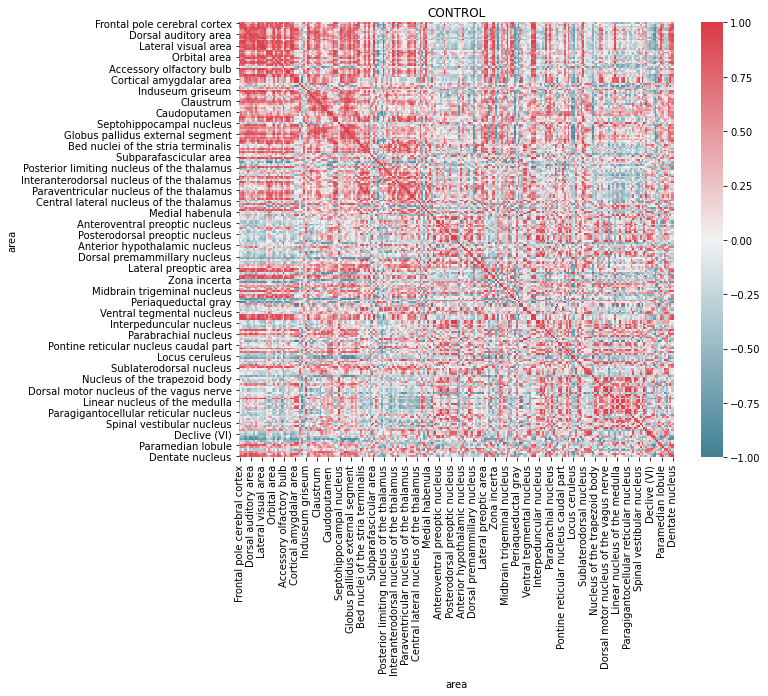

In [45]:
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr_matrix_control_energy,
    cmap=sns.diverging_palette(220, 10, as_cmap=True),
    vmin=-1.0, vmax=1.0,
    square=True, ax=ax)
ax.set_title('CONTROL')

Text(0.5, 1.0, 'FAM')

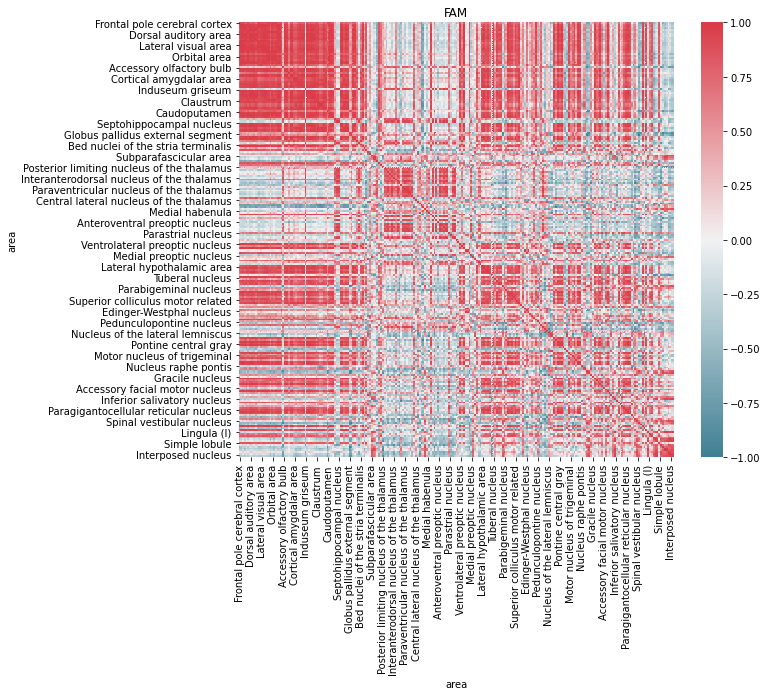

In [46]:
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr_matrix_fam_energy,
    cmap=sns.diverging_palette(220, 10, as_cmap=True),
    vmin=-1.0, vmax=1.0,
    square=True, ax=ax)
ax.set_title('FAM')

Text(0.5, 1.0, 'UNFAM')

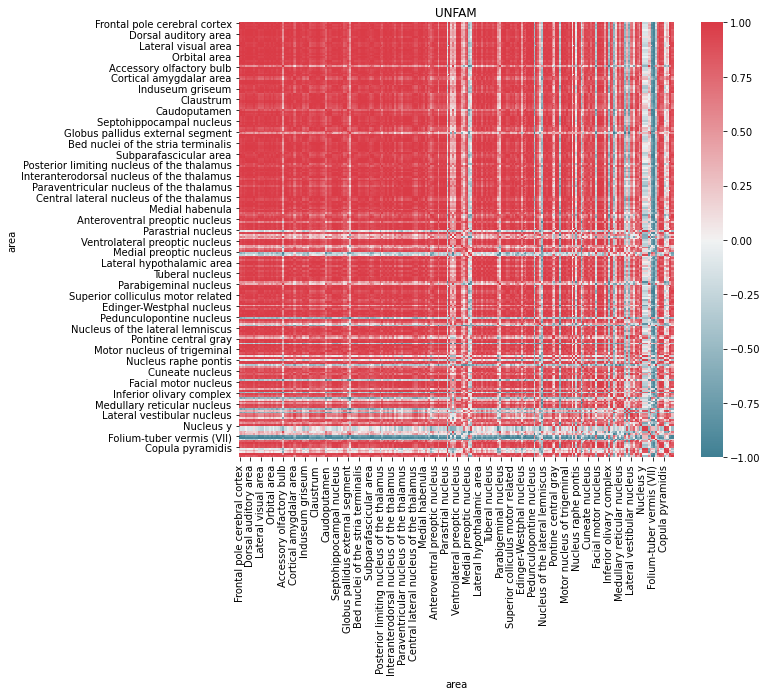

In [47]:
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr_matrix_unfam_energy,
    cmap=sns.diverging_palette(220, 10, as_cmap=True),
    vmin=-1.0, vmax=1.0,
    square=True, ax=ax)
ax.set_title('UNFAM')